<a href="https://colab.research.google.com/github/curtiscu/LYIT/blob/master/Visualizations_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizations, revisited

Redoing visualization code, this time to use the MultiIndex convenience functions, plus all the file loading refactored code. Should read a lot easier then.

# Setup env


In [0]:
# print all cell output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Google drive access

In [2]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
# test, peek at data
! ls -al '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/'

# test, modules from local  'E:\Google Drive\LYIT\Dissertation\modules'
! ls -al '/content/drive/My Drive/LYIT/Dissertation/modules/'

total 35
-rw------- 1 root root 2589 Apr 27 12:01 10_soul-groove10_102_beat_4-4.mid
-rw------- 1 root root 4793 Apr 27 12:01 1_funk-groove1_138_beat_4-4.mid
-rw------- 1 root root 3243 Apr 27 12:01 2_funk-groove2_105_beat_4-4.mid
-rw------- 1 root root 4466 Apr 27 12:01 3_soul-groove3_86_beat_4-4.mid
-rw------- 1 root root 2551 Apr 27 12:01 4_soul-groove4_80_beat_4-4.mid
-rw------- 1 root root 3798 Apr 27 12:01 5_funk-groove5_84_beat_4-4.mid
-rw------- 1 root root 3760 Apr 27 12:01 6_hiphop-groove6_87_beat_4-4.mid
-rw------- 1 root root 1894 Apr 27 12:01 7_pop-groove7_138_beat_4-4.mid
-rw------- 1 root root 2437 Apr 27 12:01 8_rock-groove8_65_beat_4-4.mid
-rw------- 1 root root 3448 Apr 27 12:01 9_soul-groove9_105_beat_4-4.mid
total 34
-rw------- 1 root root 21637 Jun  4 16:03 data_prep.py
drwx------ 2 root root  4096 May 10 13:31 __pycache__
-rw------- 1 root root  8416 Jun  2 21:24 visualizations.py


## Auto reload module

Now using library code I've created and saved to google drive which is automatically pushed to the cloud and made available to the colab env. The autoreload stuff below should help imports to 'reimport' to load changes to the library code.

It's not the quickest/ most reliable, so if in a hurry, brute force loading of changes by restarting the runtime.

In [0]:
# tool to auto reload modules.
%load_ext autoreload

# config to auto-reload all modules, handy to make 
# writing and testing modules much easier.
%autoreload 2

## Imports and accessing lib functions

In [5]:
# install required libs
!pip install mido

In [0]:
# import my modules
import sys
sys.path.append('/content/drive/My Drive/LYIT/Dissertation/modules/')
import data_prep

In [0]:
# imports
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np


# object that provides colours for charts
from itertools import cycle



In [14]:
# testing auto reload of modules 
data_prep.test_function_call('bling2')

Test function called worked! when: 2020-06-04 19:06:12.181982,  param:bling2


## Pandas display options

In [0]:
def set_pandas_display_options() -> None:
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 2000
    display.max_colwidth = 1000
    display.width = None
    # display.precision = 2  # set as needed

set_pandas_display_options()
#pd.reset_option('all')


# Visualization class

In [0]:

import data_prep as dp
from data_prep import MidiTools as mt

class Visualizations:

  def __init__(self, plot_instruments=[36, 38, 51, 42]):
    self.file_name = None # string name of file
    self.file_df = None  # raw df data from file
    self.instr_in_file = None # list of instruments in file
    self.plot_instruments = plot_instruments # filter instruments to plot
    self.plot_from_measure=1  # start plotting from bar#
    self.plot_measures=2 # plot for number of bars
    self.instr_time_filtered_df = None # data filtered for plotting
    self.bins_per_bar = None  # quantize/ smallest beat level
    self.ts_num = None # time sig beats per bar

  def __str__(self):
    return 'hello from viz class! setup for file: {}'.format(self.file_name)

  def set_instruments(self, plot_instruments):
    ''' 
      Can be used to set the instruments that are plotted, and
      the order they're rendered in.
    '''
    self.plot_instruments = plot_instruments

  def load(self, file_name):
    self.file_name = file_name    
    self.file_df, f, mtt = dp.load_file(file_name)  # load data
    self.bins_per_bar = int(mtt.bins_per_bar()) # store quantize level for plotting
    self.ts_num = int(f.ts_num()) # store musical beats per bar, for plotting


  def configure_plot(self, plot_from_measure=1, plot_measures=2, plot_instruments=[36, 38, 51, 42]):
    '''
      MUST be called before a plot call, sets up environment
    '''
    self.plot_from_measure = plot_from_measure
    self.plot_measures = plot_measures
    self.plot_instruments = plot_instruments

    # selects bars to print
    _fr = plot_from_measure
    _to = plot_from_measure+plot_measures-1
    print('filter, from: {}, to: {}'.format(_fr, _to))
    time_filtered_df = self.file_df.loc[_fr:_to]

    # check/ log available instruments in file
    instr_in_file = time_filtered_df.note.unique()
    instr_in_file.sort()
    print('  instruments available to plot: {}, names: {}'.format(instr_in_file, mt.getInstruments(instr_in_file)))

    # filter instruments if need to
    if self.plot_instruments is None:
      self.plot_instruments = instr_in_file
    self.instr_time_filtered_df = time_filtered_df[time_filtered_df['note'].isin(self.plot_instruments)]

    # grab & store some other data for doing plots
    num_instruments = len(self.plot_instruments)
    names = mt.getInstruments(self.plot_instruments)

    print('  configured instruments to plot: {}, names: {}'.format(self.plot_instruments, names ))


  def do_grid_plot(self):

    # handy sortcut
    df = self.instr_time_filtered_df

    # setup beat/ bar indicators
    #total_small_beats = list(range(1.5, (self.bins_per_bar * self.plot_measures) , 1))
    total_small_beats = list(range(1, self.bins_per_bar * self.plot_measures, 1))
    big_beat_ticks = total_small_beats[:: int(self.bins_per_bar/ self.ts_num)]
    bar_ticks = big_beat_ticks[::self.ts_num]

    # debug
    #print('total_small_beats: {}'.format(total_small_beats))
    #print('big_beat_ticks: {}'.format( big_beat_ticks))
    #print('bar_ticks: {}'.format( bar_ticks))

    # Build data structure required by broken_barh
    bag_of_instruments = {}
    for i in self.plot_instruments:
      instrument_hits = df.loc[df['note'] == i]
      plot_positions = ((instrument_hits['bar_number'] - self.plot_from_measure) * self.bins_per_bar) + instrument_hits['bar_beat_number']
      print('FOUND instrument: {}, plot_positions: {}'.format(i, plot_positions.values))
      instrument_hit_duples = []
      for next_hit in plot_positions.values:
        instrument_hit_duples.append((next_hit, 0.15))
        
      bag_of_instruments[i] = instrument_hit_duples

    print('bag_of_instruments: {}'.format(bag_of_instruments))

    # object that provides colours for charts
    cycol = cycle('bgrcmykw')  

    # create list for x-axis markers in plot
    my_xticks = list(range(0, (self.bins_per_bar * self.plot_measures)+1, 1))


    #############################################
    ## Show plot
    #############################################
    
    # grab & store some other data for doing plots
    num_instruments = len(self.plot_instruments)
    names = mt.getInstruments(self.plot_instruments)

    fig, ax = plt.subplots()
    fig.set_size_inches(12*self.plot_measures, 1+num_instruments, forward=True)
    
    # loop for each instrument
    y_axis = 0
    for i in self.plot_instruments:
      y_axis += 10
      ax.broken_barh(bag_of_instruments[int(i)], (y_axis, 7), facecolors=next(cycol));


    ax.set_ylim(5, (num_instruments*10)+10);
    ax.set_xlim(0, len(total_small_beats)+2);
    ax.set_xlabel('Plot for bars {} - {}'.format(self.plot_from_measure, self.plot_from_measure+ self.plot_measures-1));
    ax.set_yticks(list(range(15, ((num_instruments+1)*10)+5, 10)));
    ax.set_yticklabels(names);

    #Add lines for beats and bars
    for next_beat_marker in big_beat_ticks:
      ax.axvline(next_beat_marker, color='black', linestyle='dotted', linewidth=2); 
    for next_bar_marker in bar_ticks:
      ax.axvline(next_bar_marker, color='black', linestyle='solid', linewidth=2); 

    ax.set_xticks(my_xticks);
    ax.grid(True);
    
      #Add horizontal and vertical lines
    plt.axhline(0, color='black', linestyle='dotted', linewidth=2);  #horizontal line

    plt.show();



  def do_offset_plot():

    # Building data structures for plot
    bag_of_instrument_hits = {}
    for i in instruments_to_render:
      instrument_hits = instr_time_filtered_df.loc[instr_time_filtered_df['note'] == i, 'total_ticks']
      instrument_hit_array = []
      for i_time in instrument_hits:
        instrument_hit_array.append(i_time)

      bag_of_instrument_hits[i] = instrument_hit_array


    #print('bag_of_instrument_hits: {}'.format(bag_of_instrument_hits))

    bag_of_instrument_offsets = {}
    for i in instruments_to_render:
      instrument_offsets = instr_time_filtered_df.loc[instr_time_filtered_df['note'] == i, 'offset']
      instrument_offset_array = []
      for i_time in instrument_offsets:
        instrument_offset_array.append(i_time)

      bag_of_instrument_offsets[i] = instrument_offset_array

    #print('bag_of_instrument_offsets: {}'.format(bag_of_instrument_offsets))

    # create list for x-axis markers in plot
    bin_size = mtt.bin_size();
    my_xticks = list(range(int(start_tick) + int(bin_size/2), int(end_tick), bin_size))



    fig, ax = plt.subplots();
    fig.set_size_inches(12*bars_to_render, 1+num_instruments, forward=True);
    

    # loop for each instrument
    for i in instruments_to_render:
      ax.plot(bag_of_instrument_hits[i], bag_of_instrument_offsets[i], '-o', ms= 10, label=data_prep.MidiTools.mapInstrument(i));

    ax.set(xlabel='Plot for bars {} - {}'.format(bar_to_start, bar_to_start+ bars_to_render-1), ylabel='Beat offset from norm (ticks)', title='timing offset data');

    #####################################
    # Add horizontal and vertical lines
    
    ax.axhline(0, color='black', linestyle='dotted', linewidth=2);  #horizontal line
    
    # setup beat/ bar indicators
    small_beat_ticks = list(range(int(start_tick) + int(bin_size/2), int(end_tick), bin_size))
    big_beat_ticks = small_beat_ticks[:: int(mtt.bins_per_bar()/ f.ts_num())]
    bar_ticks = big_beat_ticks[::f.ts_num()]

    for next_beat_marker in big_beat_ticks:
      ax.axvline(next_beat_marker, color='black', linestyle='dotted', linewidth=2); 
    for next_bar_marker in bar_ticks:
      ax.axvline(next_bar_marker, color='black', linestyle='solid', linewidth=2); 

    

    ax.set_xticks(my_xticks);

    #ax.grid(axis='y')
    ax.grid();
    ax.legend();

    #fig.savefig("test.png")
    plt.show();





# Testing

In [188]:
v = Visualizations()
str(v)
test_file_to_load = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid'
v.load(test_file_to_load)
v.configure_plot(plot_from_measure=1, plot_measures=2, plot_instruments=None)

'hello from viz class! setup for file: None'

FILE name: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid
    loaded file: <midi file '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid' type 0, 1 tracks, 1037 messages>
    time sig: <meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>
    tempo: <meta message set_tempo tempo=434783 time=0>
    track count: 1, tracks: [<midi track 'Base Midi' 1037 messages>]
    MIDI file type: 0
    > processing track: <midi track 'Base Midi' 1037 messages>
    note_on span - first tick: 5 , last tick: 30634 
    good instruments: 4, {36.0: 'Bass Drum 1 (36)', 38.0: 'Acoustic Snare (38)', 42.0: 'Closed Hi Hat (42)', 51.0: 'Ride Cymbal 1 (51)'}
    bar info - bars in file: 16, bar quantize level: 16.0
    tick info - ticks per time sig beat: 480.0, ticks per quantize bin: 120
filter, from: 1, to: 2
  instruments available to

In [0]:
# more playing with indexing...
#v.file_df.head()
#v.file_df.index.names
#v.file_df.loc[9].loc[3]

FOUND instrument: 36, plot_positions: [ 1  3  4 11 12 17 19 27 28]
FOUND instrument: 38, plot_positions: [ 5  8 10 13 16 18 21 24 26 29 32]
FOUND instrument: 42, plot_positions: [ 1  5  9 13 17 21 25 29]
FOUND instrument: 51, plot_positions: [ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31]
bag_of_instruments: {36: [(1, 0.15), (3, 0.15), (4, 0.15), (11, 0.15), (12, 0.15), (17, 0.15), (19, 0.15), (27, 0.15), (28, 0.15)], 38: [(5, 0.15), (8, 0.15), (10, 0.15), (13, 0.15), (16, 0.15), (18, 0.15), (21, 0.15), (24, 0.15), (26, 0.15), (29, 0.15), (32, 0.15)], 42: [(1, 0.15), (5, 0.15), (9, 0.15), (13, 0.15), (17, 0.15), (21, 0.15), (25, 0.15), (29, 0.15)], 51: [(1, 0.15), (3, 0.15), (5, 0.15), (7, 0.15), (9, 0.15), (11, 0.15), (13, 0.15), (15, 0.15), (17, 0.15), (19, 0.15), (21, 0.15), (23, 0.15), (25, 0.15), (27, 0.15), (29, 0.15), (31, 0.15)]}


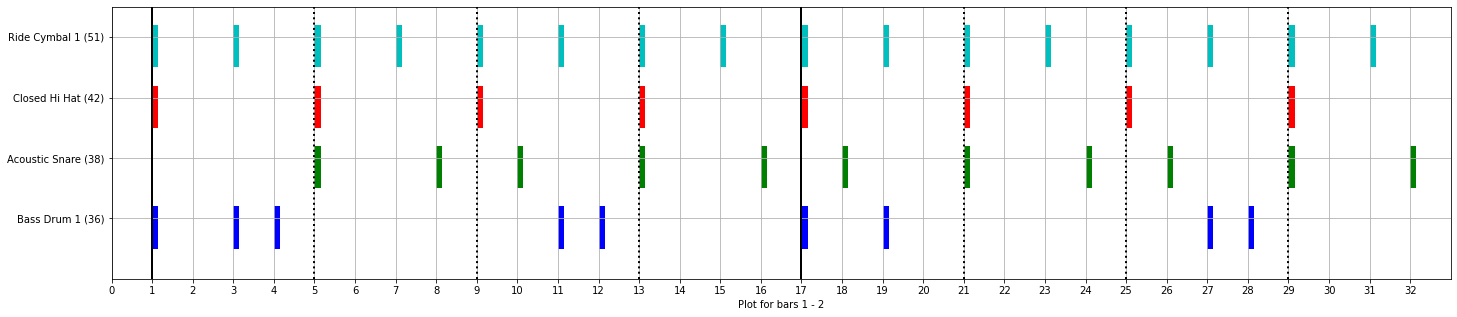

In [189]:
v.do_grid_plot()